In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import importlib.util
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from torchvision import transforms

In [72]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import importlib.util
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from PIL import Image
from torchvision import transforms

# GCN関数
class GCN():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ

# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device
        self.mean = None
        self.ZCA_matrix = None

    def fit(self, images):  # 変換行列と平均をデータから計算
        """
        Argument
        --------
        images : torchvision.datasets.cifar.CIFAR10
            入力画像（訓練データ全体）．(N, C, H, W)
        """
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x
    
    @classmethod
    def load(cls, filepath):
        state = torch.load(filepath)
        instance = cls(epsilon=state['epsilon'], device=state['device'])
        instance.mean = state['mean']
        instance.ZCA_matrix = state['ZCA_matrix']
        return instance


# カスタムデータセット
class CustomDataset(Dataset):
    def __init__(self, x_train, t_train, transform=None):
        data = x_train.astype('float32')
        # self.x_train = data
        # data = np.transpose(x_train, (0, 2, 3, 1)).astype('float32')
        self.x_train = []
        if x_train.shape[3] == 3:
            for i in range(data.shape[0]):
                self.x_train.append(Image.fromarray(np.uint8(data[i])))
        else:
            for i in range(x_train.shape[0]):
                # グレースケール画像を2D配列として扱う
                img = x_train[i].squeeze()  # (28, 28, 1) -> (28, 28)
                # 0-255の範囲にスケーリング（必要な場合）
                # img = (img * 255).astype(np.uint8)
                self.x_train.append(Image.fromarray(img, mode='L'))
        self.t_train = t_train
        if transform is None:
            self.transform = transforms.ToTensor()
        else:
            self.transform = transform

    def __len__(self):
        return len(self.x_train)
    
    def __getitem__(self, idx):
        x_train = self.transform(self.x_train[idx])
        t_train = torch.tensor(self.t_train[idx], dtype=torch.long)

        return x_train, t_train

# モデルをインポートする関数
def import_model(config):
    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../user"))
    model_path = os.path.join(base_dir, user_id, project_name, model_id, "model_config.py")
    spec = importlib.util.spec_from_file_location("Simple_NN", model_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)
    return model_module.Simple_NN()


# データセットの読込み＆前処理を行う関数
def load_and_split_data(config):
    image_shape = int(config['input_info']['change_shape'])
    transform_list = [
        transforms.Resize((image_shape, image_shape)),
        transforms.ToTensor()
    ]
    project_name = config["Project_name"]
    # dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "./dataset", project_name))
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    x_test = np.load(os.path.join(dataset_dir, "x_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))

    pretreatment = config['input_info'].get("preprocessing")
    if pretreatment == "GCN":
        print('GCN使用')
        gcn = GCN()
        transform_list.append(gcn)
    elif pretreatment == "ZCA":
        zca = ZCAWhitening.load(os.path.join(dataset_dir, f"{project_name}_zca.pth"))
        transform_list.append(zca)
        print('ZCA使用')
    
    test_size = float(config["Train_info"]["test_size"])
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size)

    transform = transforms.Compose(transform_list)

    # image_shape = config["Train_info"]["image_shape"]
    # if len(x_train.shape) == 2 and x_train.shape[1] == image_shape * image_shape:
    #     channels = 1
    #     height, width = image_shape, image_shape
    #     x_train = x_train.reshape(-1, channels, height, width)
    #     x_val = x_val.reshape(-1, channels, height, width)
    #     x_test = x_test.reshape(-1, channels, height, width)
    # elif len(x_train.shape) == 4:
    #     channels = x_train.shape[-1]
    #     height, width = x_train.shape[1], x_train.shape[2]
    #     x_train = x_train.transpose(0, 3, 1, 2)
    #     x_val = x_val.transpose(0, 3, 1, 2)
    #     x_test = x_test.transpose(0, 3, 1, 2)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test), transform

# オプティマイザを取得する関数
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name == 'SGD':
        return optim.SGD(params, lr)
    if optimizer_name == 'momentum':
        return optim.SGD(params, lr, momentum=0.8)
    if optimizer_name == 'Adam':
        return optim.Adam(params, lr)
    if optimizer_name == 'Adagrad':
        return optim.Adagrad(params, lr)
    if optimizer_name == 'RMSProp':
        return optim.RMSprop(params, lr)
    if optimizer_name == 'Adadelta':
        return optim.Adadelta(params, lr)

# ロス関数を取得する関数
def get_loss(loss_name):
    if loss_name == 'mse_loss':
        return nn.MSELoss()
    if loss_name == 'cross_entropy':
        return nn.CrossEntropyLoss()
    if loss_name == 'binary_cross_entropy':
        return nn.BCELoss()
    if loss_name == 'nll_loss':
        return nn.NLLLoss()
    if loss_name == 'hinge_embedding_loss':
        return nn.HingeEmbeddingLoss()

# モデルの訓練を行う関数
def train_model(config):
    model = import_model(config)

    (x_train, y_train), (x_val, y_val), (x_test, y_test), transform = load_and_split_data(config)

    train_info = config["Train_info"]

    image_shape = config['input_info']['change_shape']
    # transform = transforms.Compose([
    #     transforms.Resize((image_shape, image_shape)),
    #     transforms.ToTensor()
    # ])

    train_dataset = CustomDataset(x_train, y_train, transform)
    val_dataset = CustomDataset(x_val, y_val, transform)

    # train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
    # val_dataset = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
    
    train_loader = DataLoader(train_dataset, batch_size=train_info["batch"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_info["batch"], shuffle=False)

    optimizer = get_optimizer(train_info["optimizer"], model.parameters(), train_info["learning_rate"])
    loss_fn = get_loss(train_info["loss"])

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(1, train_info["epoch"]+1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_corrects += (torch.max(outputs, 1)[1] == targets).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                running_val_loss += loss.item()
                running_val_corrects += (torch.max(outputs, 1)[1] == targets).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = running_val_corrects / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f'Epoch [{epoch}/{train_info["epoch"]}], Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../user", user_id, project_name, model_id))
    os.makedirs(base_dir, exist_ok=True)
    best_model_path = os.path.join(base_dir, "best_model.pth")
    torch.save(best_model, best_model_path)
    
    photo_dir = os.path.join(base_dir, "photo")
    os.makedirs(photo_dir, exist_ok=True)
    
    plt.figure()
    plt.title("Training Accuracy")
    plt.plot(range(1, train_info["epoch"]+1), train_acc_history, label="Train Accuracy")
    plt.plot(range(1, train_info["epoch"]+1), val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(photo_dir, "accuracy_curve.png"))
    plt.close()
    
    plt.figure()
    plt.title('Training Loss')
    plt.plot(range(1, train_info["epoch"]+1), train_loss_history, label="Train Loss")
    plt.plot(range(1, train_info["epoch"]+1), val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(photo_dir, "loss_curve.png"))
    plt.close()

# 実行
config = {
    "user_id": "example_user_id",
    "Project_name": "CIFAR10",
    "model_id": "example_model",
    "input_info": {
        "change_shape": 32,
        "preprocessing": "ZCA"
    },
    "Train_info": {
        "loss": "cross_entropy",
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "batch": 16,
        "epoch": 10,
        "test_size": 0.2,
        "image_shape": 28
    }
}

train_model(config)


C:\Users\yukihito\AppData\Local\Temp\ipykernel_25916\2596923519.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filepath)


ZCA使用
Epoch [1/10], Train Acc: 0.2158, Val Acc: 0.2913, Train Loss: 2.1144, Val Loss: 1.9495


KeyboardInterrupt: 

: 

In [2]:
# カスタムデータセット
class CustomDataset(Dataset):
    def __init__(self, x_train, t_train, transform=None):
        data = x_train.astype('float32')
        # self.x_train = data
        # data = np.transpose(x_train, (0, 2, 3, 1)).astype('float32')
        self.x_train = []
        if x_train.shape[3] == 3:
            for i in range(data.shape[0]):
                self.x_train.append(Image.fromarray(np.uint8(data[i])))
        else:
            for i in range(x_train.shape[0]):
                # グレースケール画像を2D配列として扱う
                img = x_train[i].squeeze()  # (28, 28, 1) -> (28, 28)
                # 0-255の範囲にスケーリング（必要な場合）
                img = (img * 255).astype(np.uint8)
                self.x_train.append(Image.fromarray(img, mode='L'))
        self.t_train = t_train
        if transform is None:
            self.transform = transforms.ToTensor()
        else:
            self.transform = transform

    def __len__(self):
        return len(self.x_train)
    
    def __getitem__(self, idx):
        x_train = self.transform(self.x_train[idx])
        t_train = torch.tensor(self.t_train[idx], dtype=torch.long)

        return x_train, t_train

In [8]:
# GCN関数
class GCN():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ

In [3]:
# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device
        self.mean = None
        self.ZCA_matrix = None

    def fit(self, images):  # 変換行列と平均をデータから計算
        """
        Argument
        --------
        images : torchvision.datasets.cifar.CIFAR10
            入力画像（訓練データ全体）．(N, C, H, W)
        """
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x
    
    @classmethod
    def load(cls, filepath):
        state = torch.load(filepath)
        instance = cls(epsilon=state['epsilon'], device=state['device'])
        instance.mean = state['mean']
        instance.ZCA_matrix = state['ZCA_matrix']
        return instance

In [4]:
project_name = 'CIFAR10'
dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))

x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))

images = CustomDataset(x_train, y_train)
zca = ZCAWhitening()
zca.fit(images)

# 保存
state = {
    'mean': zca.mean,
    'ZCA_matrix': zca.ZCA_matrix,
    'epsilon': zca.epsilon,
    'device': zca.device
}

# 状態を保存
torch.save(state, f'{project_name}_zca.pth')

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [35]:
x_train.shape

(60000, 28, 28, 1)

In [45]:
# 保存した状態をロードして新しいインスタンスを作成
loaded_zca = ZCAWhitening.load('MNIST_zca.pth')

C:\Users\yukihito\AppData\Local\Temp\ipykernel_25916\3179076803.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filepath)


In [5]:
# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    """
    Argument
    --------
    x : np.ndarray
        入力画像．(H, W, C)

    Return
    ------
    _x : np.ndarray
        [0, 1]で正規化した画像．(H, W, C)
    """
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x


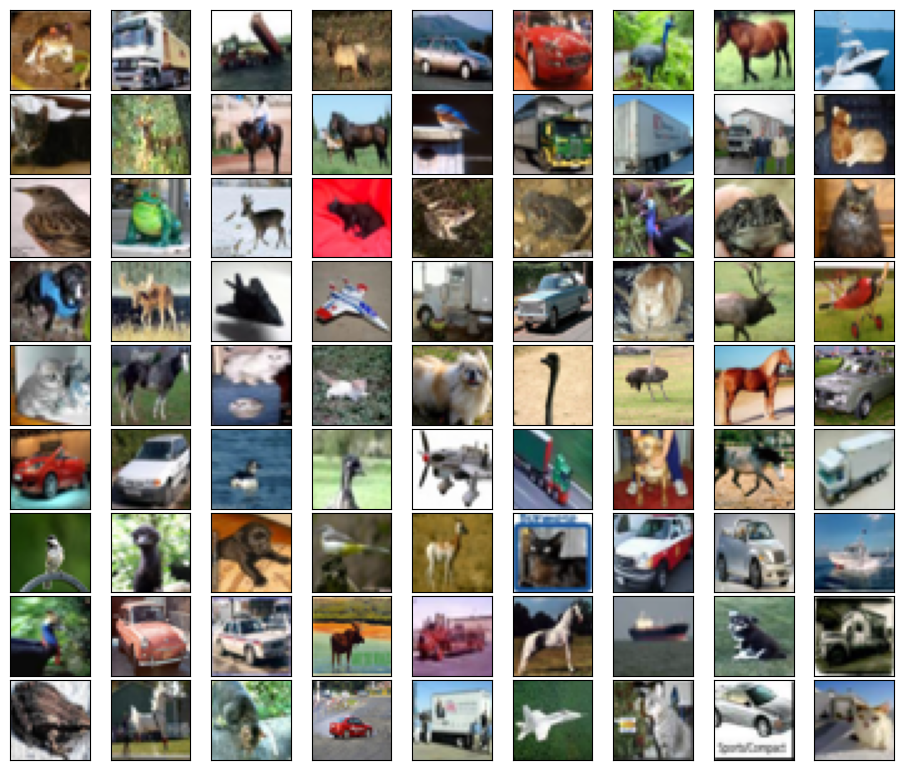

In [10]:
gcn = GCN()
transform_zca = transforms.Compose([transforms.ToTensor(),
                                    gcn])

dataloader_train_zca = torch.utils.data.DataLoader(
    CustomDataset(x_train, y_train, transform_zca),
    batch_size=1,
    shuffle=False
)

fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

i = 0
for x, _ in dataloader_train_zca:
    if x.shape[1] == 3:
        x = np.transpose(torch.squeeze(x).numpy(), (1, 2, 0))
    else:
        x = x.squeeze().numpy()
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(deprocess(x))
    # ax.imshow(x)
    i += 1
    if i >= 81:
        break

In [ ]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# デバイスを指定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# ZCA白色化の実装
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device=device):  # 計算が重いのでGPUを用いる
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        """
        Argument
        --------
        images : numpy.ndarray
            入力画像（訓練データ全体）．(N, C, H, W)
        """
        x = torch.tensor(images[0]).reshape(1, -1).to(self.device)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = torch.tensor(images[i]).reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

# データセットから画像を取得する関数
def load_image_from_project(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    # ここでは1枚の画像を取得する
    return x_train[0]

# データセットをロードする関数
def load_dataset_from_project(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    x_test = np.load(os.path.join(dataset_dir, "x_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))
    return x_train, y_train, x_test, y_test

# 画像を表示する関数
def show_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

# GCNの実装（関数として定義）
def global_contrast_normalization(image, scale=1., epsilon=1e-8):
    """
    グローバルコントラスト正規化 (GCN) の実装
    """
    mean = np.mean(image)
    std = np.sqrt(np.var(image) + epsilon)
    return scale * (image - mean) / std

# メイン処理
if __name__ == "__main__":
    config = {
        "Project_name": "CIFAR-10"
    }

    # データセットをロード
    x_train, y_train, x_test, y_test = load_dataset_from_project(config)

    # データセットから1枚の画像を取得
    sample_image = x_train[0]

    # 画像が3次元配列であることを確認
    if len(sample_image.shape) == 3:  # (H, W, C) の場合
        sample_image = sample_image.reshape(1, *sample_image.shape)  # (1, H, W, C) に変換

    # ZCAホワイトニングを適用するために準備
    zca = ZCAWhitening(device=device)
    zca.fit(x_train)

    # 画像をテンソルに変換
    sample_image_tensor = torch.tensor(sample_image).permute(0, 3, 1, 2).float()  # (1, C, H, W)

    # GCNを適用
    gcn_image = global_contrast_normalization(sample_image.copy())
    gcn_image = gcn_image.reshape(32, 32, 3)  # 画像の形状に戻す

    # ZCAホワイトニングを適用
    zca_image = zca(sample_image_tensor).permute(0, 2, 3, 1).numpy()  # (1, H, W, C)
    zca_image = zca_image.reshape(32, 32, 3)  # 画像の形状に戻す

    # 元の画像を表示
    original_image = sample_image.reshape(32, 32, 3)
    show_image(original_image, "Original Image")

    # GCN画像を表示
    show_image(gcn_image, "GCN Image")

    # ZCAホワイトニング画像を表示
    show_image(zca_image, "ZCA Whitening Image")


: 

In [3]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import importlib.util
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"ImageClassification:{device}")

# オプティマイザを取得する関数
def get_optimizer(optimizer_name, params, lr):
    if optimizer_name == 'SGD':
        return optim.SGD(params, lr)
    if optimizer_name == 'momentum':
        return optim.SGD(params, lr, momentum=0.8)
    if optimizer_name == 'Adam':
        return optim.Adam(params, lr)
    if optimizer_name == 'Adagrad':
        return optim.Adagrad(params, lr)
    if optimizer_name == 'RMSProp':
        return optim.RMSprop(params, lr)
    if optimizer_name == 'Adadelta':
        return optim.Adadelta(params, lr)

# ロス関数を取得する関数
def get_loss(loss_name):
    if loss_name == 'mse_loss':
        return nn.MSELoss()
    if loss_name == 'cross_entropy':
        return nn.CrossEntropyLoss()
    if loss_name == 'binary_cross_entropy':
        return nn.BCELoss()
    if loss_name == 'nll_loss':
        return nn.NLLLoss()
    if loss_name == 'hinge_embedding_loss':
        return nn.HingeEmbeddingLoss()

# GCN関数
def gcn(x):
    mean = np.mean(x, axis=(1,2,3), keepdims=True)
    std = np.std(x, axis=(1,2,3), keepdims=True)
    return (x - mean) / (std + 1.E-6)

# 新しいZCA Whiteningクラス
class ZCA_Whitening:
    def __init__(self, epsilon=1E-6):
        self.epsilon = epsilon
        self.mean = None
        self.PCA_mat = None
        
    def fit(self, x):
        x = x.astype(np.float64)
        x = x.reshape(x.shape[0],-1)
        self.mean = np.mean(x, axis=0)
        x -= self.mean
        cov_mat = np.dot(x.T, x) / x.shape[0]
        A, L, _ = np.linalg.svd(cov_mat)
        self.ZCA_mat = np.dot(A, np.dot(np.diag(1. / (np.sqrt(L) + self.epsilon)), A.T))
            
    def transform(self, x):
        shape = x.shape
        x = x.astype(np.float64)
        x = x.reshape(x.shape[0],-1)
        x -= self.mean
        x = np.dot(x, self.ZCA_mat)
        return x.reshape(shape)

# モデルをインポートする関数
def import_model(config):
    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../user"))
    model_path = os.path.join(base_dir, user_id, project_name, model_id, "model_config.py")
    spec = importlib.util.spec_from_file_location("Simple_NN", model_path)
    model_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(model_module)
    return model_module.Simple_NN()

# データセットの読込み＆前処理を行う関数
def load_and_split_data(config):
    project_name = config["Project_name"]
    dataset_dir = os.path.abspath(os.path.join(os.getcwd(), "../dataset", project_name))
    
    x_train = np.load(os.path.join(dataset_dir, "x_train.npy"))
    y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
    x_test = np.load(os.path.join(dataset_dir, "x_test.npy"))
    y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))

    pretreatment = config["Train_info"].get("Pretreatment", "none")
    if pretreatment == "GCN":
        x_train = gcn(x_train)
        x_test = gcn(x_test)
    elif pretreatment == "ZCA":
        zca = ZCA_Whitening()
        zca.fit(x_train)
        x_train = zca.transform(x_train)
        x_test = zca.transform(x_test)
    
    test_size = config["Train_info"]["test_size"]
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size)

    image_shape = config["Train_info"]["image_shape"]
    if len(x_train.shape) == 2 and x_train.shape[1] == image_shape * image_shape:
        channels = 1
        height, width = image_shape, image_shape
        x_train = x_train.reshape(-1, channels, height, width)
        x_val = x_val.reshape(-1, channels, height, width)
        x_test = x_test.reshape(-1, channels, height, width)
    elif len(x_train.shape) == 4:
        channels = x_train.shape[-1]
        height, width = x_train.shape[1], x_train.shape[2]
        x_train = x_train.transpose(0, 3, 1, 2)
        x_val = x_val.transpose(0, 3, 1, 2)
        x_test = x_test.transpose(0, 3, 1, 2)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# モデルの訓練を行う関数
def train_model(config):
    model = import_model(config).to(device)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_and_split_data(config)

    train_info = config["Train_info"]

    train_dataset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
    val_dataset = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
    
    train_loader = DataLoader(train_dataset, batch_size=train_info["batch"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_info["batch"], shuffle=False)

    optimizer = get_optimizer(train_info["optimizer"], model.parameters(), train_info["learning_rate"])
    loss_fn = get_loss(train_info["loss"])

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    best_val_loss = float('inf')
    best_model = None
    
    for epoch in range(1, train_info["epoch"]+1):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_corrects += (torch.max(outputs, 1)[1] == targets).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        
        model.eval()
        running_val_loss = 0.0
        running_val_corrects = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                running_val_loss += loss.item()
                running_val_corrects += (torch.max(outputs, 1)[1] == targets).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = running_val_corrects / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        
        print(f'Epoch [{epoch}/{train_info["epoch"]}], Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    user_id = config["user_id"]
    project_name = config["Project_name"]
    model_id = config["model_id"]
    base_dir = os.path.abspath(os.path.join(os.getcwd(), "../user", user_id, project_name, model_id))
    os.makedirs(base_dir, exist_ok=True)
    best_model_path = os.path.join(base_dir, "best_model.pth")
    torch.save(best_model, best_model_path)
    
    photo_dir = os.path.join(base_dir, "photo")
    os.makedirs(photo_dir, exist_ok=True)
    
    plt.figure()
    plt.title("Training Accuracy")
    plt.plot(range(1, train_info["epoch"]+1), train_acc_history, label="Train Accuracy")
    plt.plot(range(1, train_info["epoch"]+1), val_acc_history, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(os.path.join(photo_dir, "accuracy_curve.png"))
    plt.close()
    
    plt.figure()
    plt.title('Training Loss')
    plt.plot(range(1, train_info["epoch"]+1), train_loss_history, label="Train Loss")
    plt.plot(range(1, train_info["epoch"]+1), val_loss_history, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(photo_dir, "loss_curve.png"))
    plt.close()

config = {
    "user_id": "example_user_id",
    "Project_name": "CIFAR10",
    "model_id": "example_model",
    "Train_info": {
        "Pretreatment": "GCA",
        "loss": "cross_entropy",
        "optimizer": "Adam",
        "learning_rate": 0.001,
        "batch": 16,
        "epoch": 10,
        "test_size": 0.2,
        "image_shape": 28
    }
}

train_model(config)

ImageClassification:cuda
Epoch [1/10], Train Acc: 0.2597, Val Acc: 0.3223, Train Loss: 1.9971, Val Loss: 1.8501
Epoch [2/10], Train Acc: 0.3170, Val Acc: 0.3213, Train Loss: 1.8575, Val Loss: 1.8496
Epoch [3/10], Train Acc: 0.3393, Val Acc: 0.3366, Train Loss: 1.7977, Val Loss: 1.8393
Epoch [4/10], Train Acc: 0.3505, Val Acc: 0.3173, Train Loss: 1.7655, Val Loss: 1.8451
Epoch [5/10], Train Acc: 0.3605, Val Acc: 0.3594, Train Loss: 1.7347, Val Loss: 1.7686
Epoch [6/10], Train Acc: 0.3715, Val Acc: 0.3550, Train Loss: 1.7072, Val Loss: 1.7882
Epoch [7/10], Train Acc: 0.3818, Val Acc: 0.3683, Train Loss: 1.6861, Val Loss: 1.7411
Epoch [8/10], Train Acc: 0.3912, Val Acc: 0.3772, Train Loss: 1.6636, Val Loss: 1.6963
Epoch [9/10], Train Acc: 0.3992, Val Acc: 0.4044, Train Loss: 1.6380, Val Loss: 1.6331
Epoch [10/10], Train Acc: 0.4041, Val Acc: 0.3852, Train Loss: 1.6291, Val Loss: 1.6998
